In [1]:
! mkdir .kaggle
! mv kaggle.json .kaggle
! ls -a .kaggle

.  ..  kaggle.json


In [2]:
! mv .kaggle ~/.

In [3]:
! ls -a ~/.

.   .bashrc  .config   .jupyter  .keras		.local	.profile    .wget-hsts
..  .cache   .ipython  .kaggle	 .launchpadlib	.npm	.tmux.conf


In [ ]:
! kaggle datasets download -d jangedoo/utkface-new
! unzip utkface-new.zip

In [2]:
! pip install -q wandb

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback

In [4]:
wandb.login()

wandb: Currently logged in as: gharabadiyan. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project="Age_Prediction", entity="gharabadiyan")

In [6]:
width = height =  150
batch_size = 32

In [7]:
images = []  #X
ages = []    #Y

for image_name in os.listdir('/content/UTKFace'):
  age = int(image_name.split('_')[0])
  ages.append(age)

  image = cv2.imread(f"/content/UTKFace/{image_name}")
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(width,height))
  images.append(image)

In [8]:
images = pd.Series(images,name='Images') # covenrt list of python to series
ages = pd.Series(ages,name='Ages')

dataframe = pd.concat([images,ages],axis=1)
dataframe.head()

,Images,Ages
0,"[[[189, 174, 177], [189, 174, 176], [189, 176,...",60
1,"[[[126, 82, 53], [132, 89, 58], [138, 99, 66],...",12
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8
3,"[[[215, 206, 67], [231, 223, 82], [226, 219, 7...",9
4,"[[[50, 27, 19], [46, 23, 16], [44, 21, 15], [4...",21


8


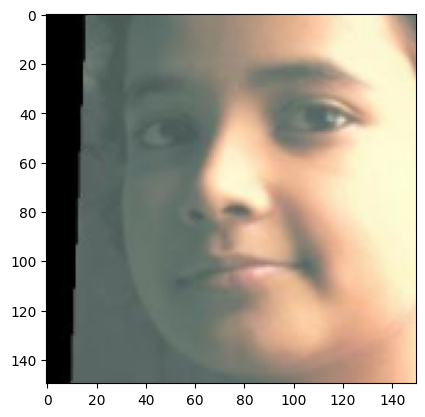

In [9]:
print(dataframe['Ages'][2])
plt.imshow(dataframe['Images'][2])
plt.show()

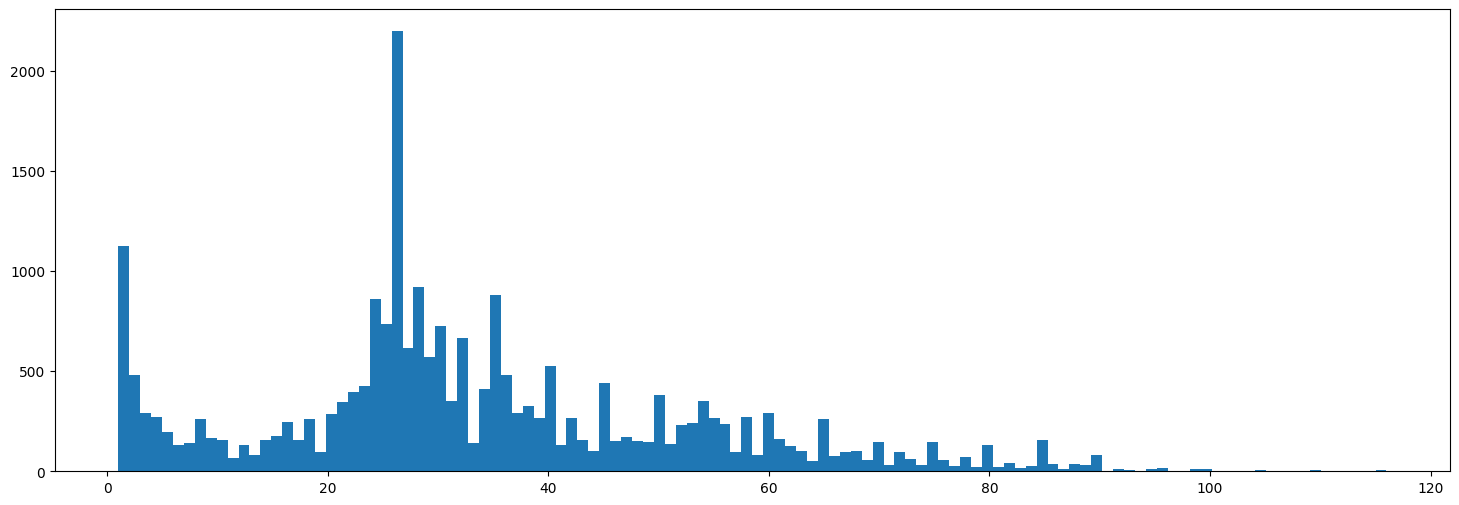

In [10]:
plt.figure(figsize=(18,6))
plt.hist(dataframe['Ages'],bins=dataframe['Ages'].max())
plt.show()

In [11]:
under_30 = dataframe[(dataframe['Ages']>= 20)&(dataframe['Ages']< 30)]
under_30_new = under_30.sample(frac=0.3)

up_30  = dataframe[dataframe['Ages']>30]

dataframe = pd.concat([under_30_new,up_30],axis=0)

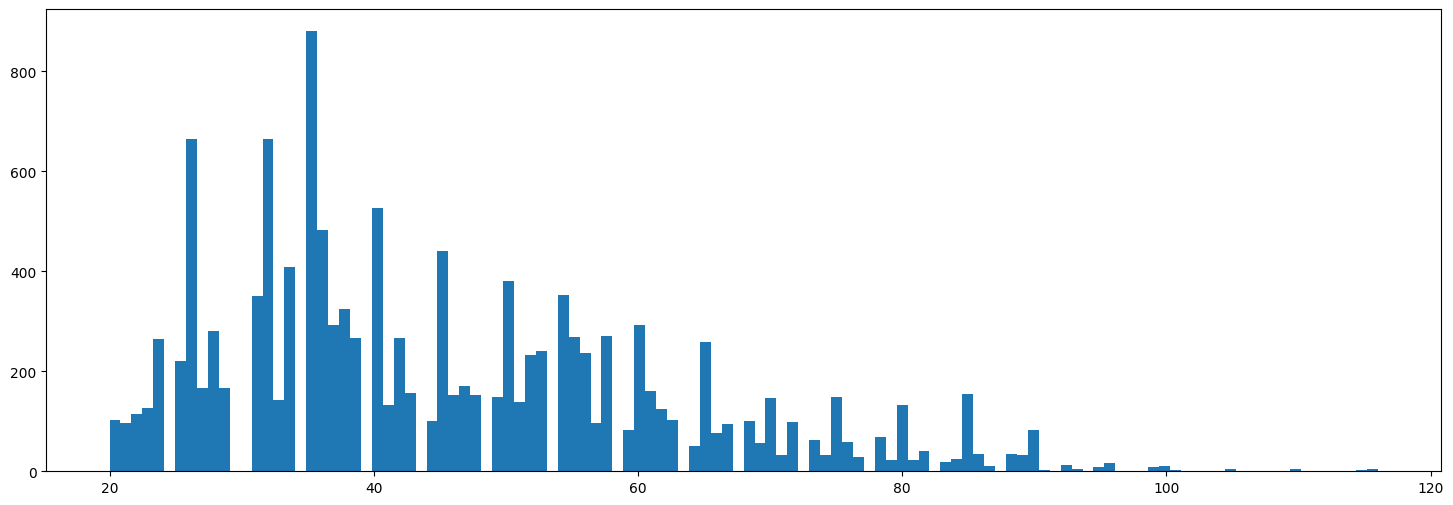

In [12]:
plt.figure(figsize=(18,6))
plt.hist(dataframe['Ages'],bins=dataframe['Ages'].max())
plt.show()

In [13]:

dataframe = dataframe[dataframe['Ages'] < 80]


In [14]:
X = np.array(dataframe['Images'].values.tolist())
Y = np.array(dataframe['Ages'].values.tolist())

In [15]:
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)


(10061, 150, 150, 3)
(2516, 150, 150, 3)
(10061,)
(2516,)


In [16]:
del X
del Y
del dataframe
del images
del ages

In [17]:
idg = ImageDataGenerator(

    rescale = 1./255,
    horizontal_flip = True,
)

train_data = idg.flow(
    X_train,
    Y_train,
    batch_size = batch_size,
    shuffle=True,
)

val_data = idg.flow(
    X_val,
    Y_val,
    batch_size = batch_size,
    shuffle=False,
)

In [18]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(width,height,3),
    weights='imagenet',
    include_top=False,
    pooling='avg'

)

In [19]:
model = tf.keras.Sequential([
                             base_model,
                             Dropout(0.2),
                             Dense(1)
])

In [20]:
model.compile(optimizer=Adam(lr=0.1),
              loss=tf.keras.losses.mae)

In [21]:
model.fit(train_data,validation_data=val_data,epochs=20,callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
315/315 [==============================] - ETA: 0s - loss: 9.5237

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231111_092328-xhxiqq5j/files/model-best)... Done. 0.1s


315/315 [==============================] - 103s 185ms/step - loss: 9.5237 - val_loss: 41.5534
Epoch 2/20
315/315 [==============================] - 29s 91ms/step - loss: 6.6744 - val_loss: 55.3251
Epoch 3/20
315/315 [==============================] - ETA: 0s - loss: 6.3746

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231111_092328-xhxiqq5j/files/model-best)... Done. 0.2s


315/315 [==============================] - 56s 178ms/step - loss: 6.3746 - val_loss: 27.4359
Epoch 4/20
315/315 [==============================] - ETA: 0s - loss: 6.1905

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231111_092328-xhxiqq5j/files/model-best)... Done. 0.1s


315/315 [==============================] - 56s 176ms/step - loss: 6.1905 - val_loss: 19.5220
Epoch 5/20
315/315 [==============================] - 29s 91ms/step - loss: 5.9982 - val_loss: 19.6262
Epoch 6/20
315/315 [==============================] - ETA: 0s - loss: 5.8899

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231111_092328-xhxiqq5j/files/model-best)... Done. 0.1s


315/315 [==============================] - 53s 167ms/step - loss: 5.8899 - val_loss: 14.6641
Epoch 7/20
315/315 [==============================] - ETA: 0s - loss: 5.7484

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231111_092328-xhxiqq5j/files/model-best)... Done. 0.2s


315/315 [==============================] - 53s 169ms/step - loss: 5.7484 - val_loss: 9.8185
Epoch 8/20
315/315 [==============================] - ETA: 0s - loss: 5.5704

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231111_092328-xhxiqq5j/files/model-best)... Done. 0.1s


315/315 [==============================] - 56s 178ms/step - loss: 5.5704 - val_loss: 8.8539
Epoch 9/20
315/315 [==============================] - 29s 92ms/step - loss: 5.5079 - val_loss: 9.2260
Epoch 10/20
315/315 [==============================] - ETA: 0s - loss: 5.4014

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231111_092328-xhxiqq5j/files/model-best)... Done. 0.1s


315/315 [==============================] - 53s 168ms/step - loss: 5.4014 - val_loss: 8.7005
Epoch 11/20
315/315 [==============================] - 28s 90ms/step - loss: 5.2592 - val_loss: 12.0750
Epoch 12/20
315/315 [==============================] - ETA: 0s - loss: 5.1525

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231111_092328-xhxiqq5j/files/model-best)... Done. 0.2s


315/315 [==============================] - 54s 170ms/step - loss: 5.1525 - val_loss: 7.1689
Epoch 13/20
315/315 [==============================] - 28s 87ms/step - loss: 5.0813 - val_loss: 7.5638
Epoch 14/20
315/315 [==============================] - 30s 94ms/step - loss: 4.9477 - val_loss: 7.7736
Epoch 15/20
315/315 [==============================] - 28s 90ms/step - loss: 4.8630 - val_loss: 10.3876
Epoch 16/20
315/315 [==============================] - 29s 91ms/step - loss: 4.7720 - val_loss: 7.4461
Epoch 17/20
315/315 [==============================] - 28s 90ms/step - loss: 4.6530 - val_loss: 8.3962
Epoch 18/20
315/315 [==============================] - 28s 90ms/step - loss: 4.5738 - val_loss: 8.3142
Epoch 19/20
315/315 [==============================] - 28s 88ms/step - loss: 4.4688 - val_loss: 7.2361
Epoch 20/20
315/315 [==============================] - 28s 90ms/step - loss: 4.3724 - val_loss: 8.8202


In [22]:
model.save('age.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Face Alignment

In [23]:
! pip install -q deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 906.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.3 MB/s eta 0:00:00


⚠️ Function detectFace is deprecated! Use extract_faces instead of this.
⚠️ Function detectFace is deprecated! Use extract_faces instead of this.
⚠️ Function detectFace is deprecated! Use extract_faces instead of this.
1/1 [==============================] - 0s 37ms/step


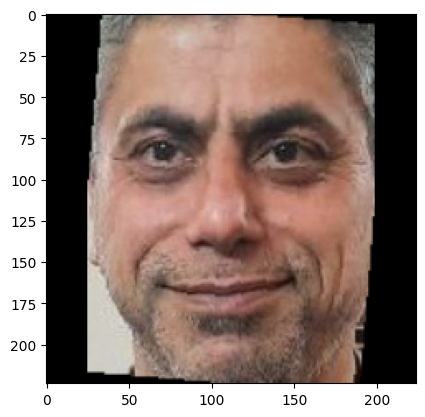

In [38]:
from deepface import DeepFace
backends = ['opencv', 'ssd', 'mtcnn']

for backend in backends:
   detected_face = DeepFace.detectFace("/content/photo_2023-11-08_13-44-10.jpg", detector_backend = backend)
plt.imshow(detected_face)
plt.imsave('detected_face.jpg',detected_face)

## Infrence

1/1 [==============================] - 0s 44ms/step
Age: 47.35273


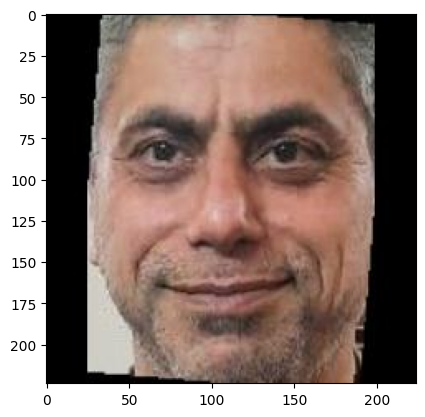

In [39]:
image = cv2.imread('/content/detected_face.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

img = cv2.resize(image,(width,height))

ar = np.asarray(img)

ar = ar.astype('float32')
ar /= 255.0
ar = ar.reshape(-1, width, height, 3)

result = model.predict(ar)
print('Age:',result[0][0])

⚠️ Function detectFace is deprecated! Use extract_faces instead of this.
⚠️ Function detectFace is deprecated! Use extract_faces instead of this.
⚠️ Function detectFace is deprecated! Use extract_faces instead of this.
1/1 [==============================] - 0s 23ms/step


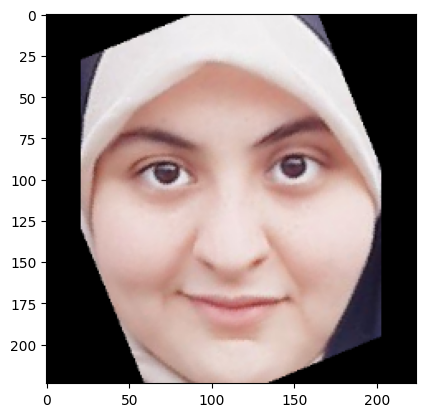

In [40]:
from deepface import DeepFace
backends = ['opencv', 'ssd', 'mtcnn']

for backend in backends:
   detected_face = DeepFace.detectFace("/content/photo_2023-11-10_19-17-54.jpg", detector_backend = backend)
plt.imshow(detected_face)
plt.imsave('detected_face.jpg',detected_face)

1/1 [==============================] - 0s 106ms/step
Age: 27.645504


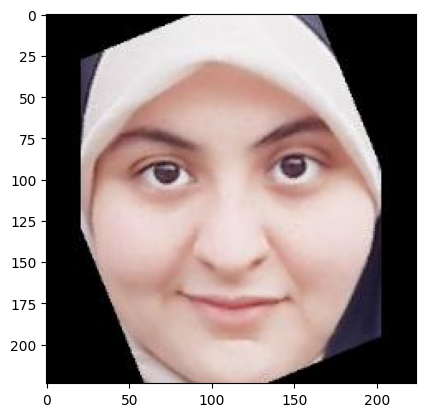

In [41]:
image = cv2.imread('/content/detected_face.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

img = cv2.resize(image,(width,height))

ar = np.asarray(img)

ar = ar.astype('float32')
ar /= 255.0
ar = ar.reshape(-1, width, height, 3)

result = model.predict(ar)
print('Age:',result[0][0])

⚠️ Function detectFace is deprecated! Use extract_faces instead of this.
⚠️ Function detectFace is deprecated! Use extract_faces instead of this.
⚠️ Function detectFace is deprecated! Use extract_faces instead of this.
1/1 [==============================] - 0s 21ms/step


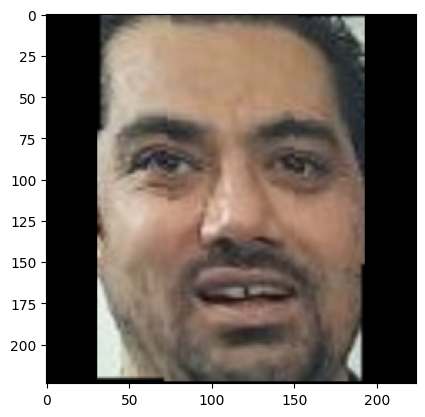

In [45]:
from deepface import DeepFace
backends = ['opencv', 'ssd', 'mtcnn']

for backend in backends:
   detected_face = DeepFace.detectFace("/content/photo_2023-11-08_13-43-41.jpg", detector_backend = backend)
plt.imshow(detected_face)
plt.imsave('detected_face.jpg',detected_face)

1/1 [==============================] - 0s 27ms/step
Age: 41.602577


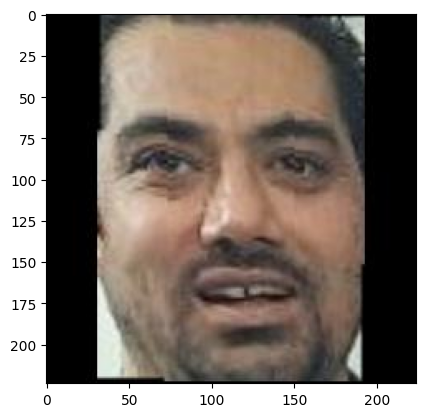

In [46]:
image = cv2.imread('/content/detected_face.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

img = cv2.resize(image,(width,height))

ar = np.asarray(img)

ar = ar.astype('float32')
ar /= 255.0
ar = ar.reshape(-1, width, height, 3)

result = model.predict(ar)
print('Age:',result[0][0])